### 1. setup and imports

In [33]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Add project root to path
if str(Path.cwd().parent) not in sys.path:
    sys.path.append(str(Path.cwd().parent))

from src.config import MODELS_DIR, PROCESSED_DATA_DIR 
from src.models.anomaly_detector import HybridAnomalyDetector

### 2. Load model and test data

In [34]:
# NOTE: We assume 'test_features.csv' contains the features (X) and 
# the ground truth label (y_true) for evaluation.
test_data_path = PROCESSED_DATA_DIR / 'golden_test_data.csv'
model_path = MODELS_DIR / 'anomaly_detector.pkl'

proceed = True

df_test = None
X_test = None
y_true = None

# Feature order expected by the training pipeline
feature_cols = [
    'article_count', 'avg_sentiment', 'sentiment_std',
    'sentiment_min', 'sentiment_max', 'avg_engagement',
    'engagement_std', 'unique_sources', 'unique_categories',
    'pct_political', 'pct_economic', 'pct_infrastructure', 'pct_tourism',
    'sentiment_velocity', 'sentiment_acceleration'
]

def _fail(msg):
    global proceed
    print(msg)
    proceed = False

try:
    # 1. Load Test Data
    if test_data_path.exists():
        df_test = pd.read_csv(test_data_path)
        if 'y_true' not in df_test.columns:
            _fail(" test_features.csv is missing 'y_true' column. Add ground-truth labels and rerun.")
        else:
            # Ensure all required feature columns exist
            missing = [c for c in feature_cols if c not in df_test.columns]
            if missing:
                _fail(f"Missing required feature columns in test data: {missing}")
            else:
                # Reorder columns to match training order
                X_test = df_test[feature_cols].values
                y_true = df_test['y_true'].values
                print(f"Loaded {len(df_test)} labeled test samples from {test_data_path}.")
    else:
        # Optional: look for a fallback features file
        alt_files = sorted(PROCESSED_DATA_DIR.glob('features_*.csv'))
        if alt_files:
            latest_alt = alt_files[-1]
            _fail(f" Missing test_features.csv. Found {latest_alt.name} but it has no labels; add 'y_true' to evaluate.")
        else:
            _fail(" Missing test_features.csv and no fallback features_*.csv found. Generate a labeled test set first.")
    
    # 2. Load Trained Model
    if proceed:
        detector = HybridAnomalyDetector()
        detector.load(model_path)
        print("Loaded trained anomaly_detector model.")

except Exception as e:
    _fail(f" Error loading data or model. Ensure model training was successful: {e}")

Loaded 550 labeled test samples from c:\Users\WW\Documents\modelX final round try 2\data\processed\golden_test_data.csv.
Loaded trained anomaly_detector model.



### 3. predict and evaluate

Selected threshold for best F1 (ties -> higher precision): 0.90
Precision: 1.000, Recall: 1.000, F1: 1.000

--- Model Performance Metrics (tuned threshold) ---
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00        50

    accuracy                           1.00       550
   macro avg       1.00      1.00      1.00       550
weighted avg       1.00      1.00      1.00       550



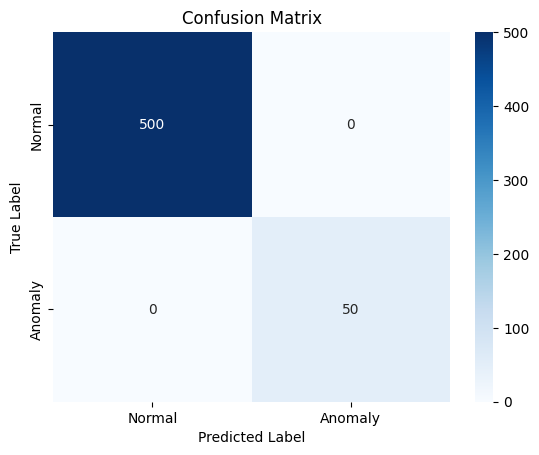

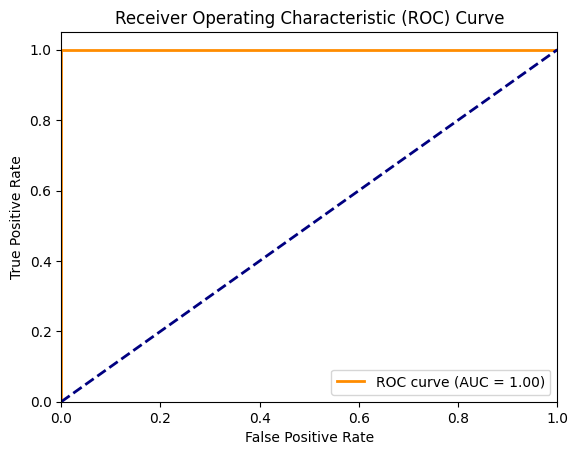

Final AUC Score: 1.0000

 Evaluation complete. Metrics saved.


In [35]:
# Predict and evaluate only if data/model loaded
if not proceed:
    print("Skipping evaluation because test data or labels are missing. Please provide test_features.csv with y_true.")
else:
    # Predict the anomaly scores (0 to 1) and binary predictions (-1 for anomaly, 1 for normal)
    raw_scores = detector.predict(X_test, return_scores=True)
    # Baseline binary (HybridAnomalyDetector returns -1 for anomaly, 1 for normal)
    y_pred_binary = (detector.predict(X_test) == -1).astype(int)  # 1 = anomaly

    # --- Threshold sweep to improve precision/recall trade-off ---
    from sklearn.metrics import precision_recall_fscore_support
    thresholds = np.linspace(0.05, 0.95, 19)
    sweep = []
    for thr in thresholds:
        preds = (raw_scores >= thr).astype(int)  # scores are higher = more anomalous
        p, r, f1, _ = precision_recall_fscore_support(y_true, preds, average='binary', zero_division=0)
        sweep.append((thr, p, r, f1))
    # pick best F1; if tie, higher precision
    sweep_sorted = sorted(sweep, key=lambda x: (x[3], x[1]), reverse=True)
    best_thr, best_p, best_r, best_f1 = sweep_sorted[0]
    y_pred_tuned = (raw_scores >= best_thr).astype(int)

    print(f"Selected threshold for best F1 (ties -> higher precision): {best_thr:.2f}")
    print(f"Precision: {best_p:.3f}, Recall: {best_r:.3f}, F1: {best_f1:.3f}\n")

    # Use tuned predictions for metrics/plots
    y_scores = raw_scores
    y_pred_binary = y_pred_tuned

    print("--- Model Performance Metrics (tuned threshold) ---")
    print("Classification Report:\n", classification_report(y_true, y_pred_binary, zero_division=0))

    # 3.2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 3.3. ROC Curve and AUC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Final AUC Score: {roc_auc:.4f}")

    # Save metrics for final report
    metrics = {
        'AUC': roc_auc,
        'BestThreshold': float(best_thr),
        'Precision': float(best_p),
        'Recall': float(best_r),
        'F1': float(best_f1)
    }
    with open(PROCESSED_DATA_DIR / 'evaluation_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=4)

    print("\n Evaluation complete. Metrics saved.")